In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import warnings

warnings.simplefilter("ignore", UserWarning)

# Завантаження та підготовка датасету Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape)  
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [2]:
# Додавання каналу до зображень
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)

# Перетворення сірого зображення на RGB
x_train = tf.image.grayscale_to_rgb(x_train)
x_test = tf.image.grayscale_to_rgb(x_test)

# Зміна розміру зображень до (32, 32)
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))

# Масштабування пікселів зображень до діапазону [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Конвертація міток у формат one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Перевірка розмірів даних
print(x_train.shape)  # Повинно вивести (60000, 32, 32, 3)
print(x_test.shape)   # Повинно вивести (10000, 32, 32, 3)


(60000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Виведення формату першого пакету даних
print(next(iter(train_dataset))[0].shape)
print(next(iter(test_dataset))[0].shape)
test_dataset

(32, 32, 32, 3)
(32, 32, 32, 3)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float64, name=None))>

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=32)

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings

# Model setup
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Fine-tuning some layers of VGG16
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

inputs = tf.keras.Input(shape=(32, 32, 3))
x = conv_base(inputs, training=True)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["acc"]
)

# Callbacks for early stopping, checkpointing, and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,982,474 (57.15 MB)

 Trainable params: 7,347,210 (28.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [5]:
# Training the model with callbacks
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Loading the best model after training
#model.load_weights('best_model.h5')

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 594s 316ms/step - acc: 0.6244 - loss: 1.0677 - val_acc: 0.8126 - val_loss: 0.5050 - learning_rate: 2.0000e-05
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 568s 303ms/step - acc: 0.7871 - loss: 0.5844 - val_acc: 0.8218 - val_loss: 0.4853 - learning_rate: 2.0000e-05
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 572s 305ms/step - acc: 0.8042 - loss: 0.5302 - val_acc: 0.8390 - val_loss: 0.4332 - learning_rate: 2.0000e-05
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 578s 308ms/step - acc: 0.8162 - loss: 0.5003 - val_acc: 0.8409 - val_loss: 0.4301 - learning_rate: 2.0000e-05
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 570s 304ms/step - acc: 0.8255 - loss: 0.4802 - val_acc: 0.8363 - val_loss: 0.4374 - learning_rate: 2.0000e-05
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 576s 307ms/step - acc: 0.8276 - loss: 0.4647 - val_acc: 0.8569 - val_loss: 0.3887 - learning_rate: 2.0000e-05
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 580s 309ms/step - acc: 0.8326 - loss: 0.4559 -

313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - acc: 0.8770 - loss: 0.3534
Test accuracy: 0.8718


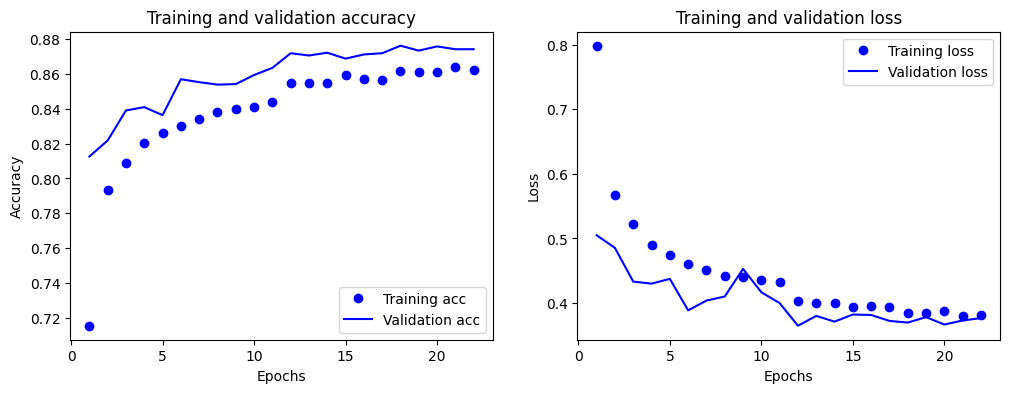

In [6]:
import matplotlib.pyplot as plt
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Plotting the results
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step


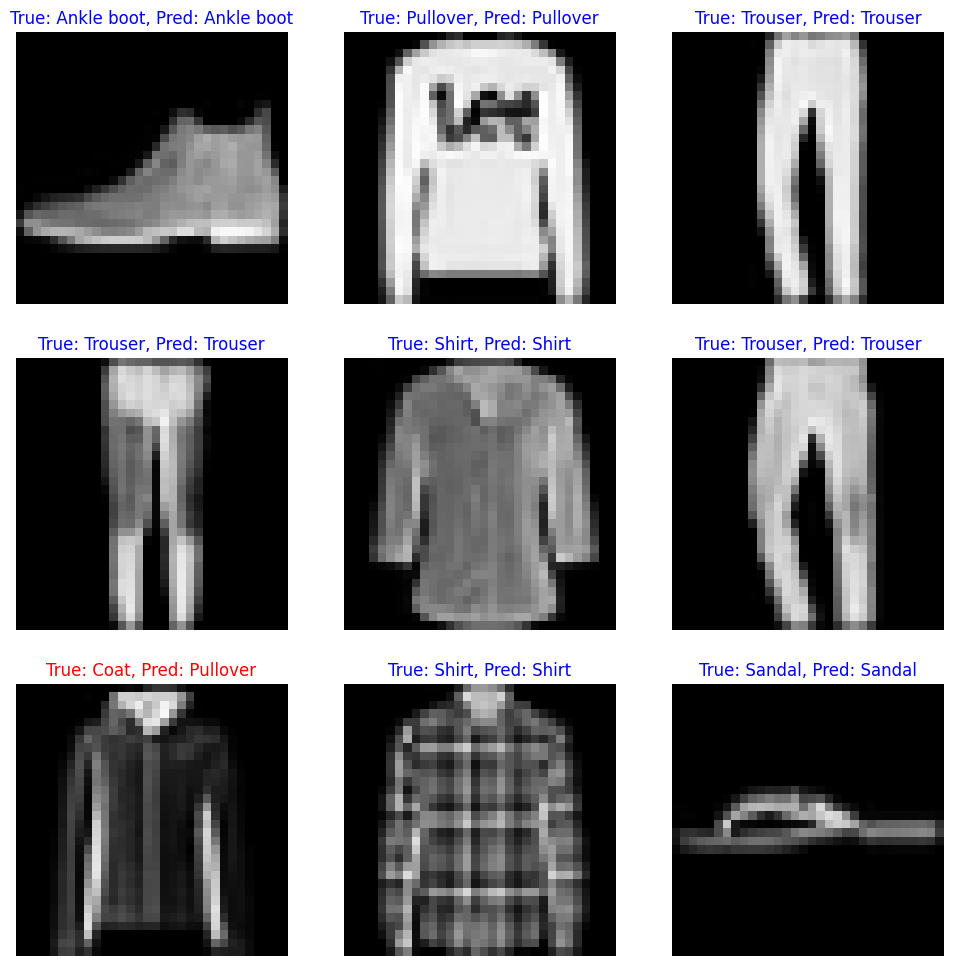

In [11]:
import numpy as np
# Прогнозування на тестових даних
# Make predictions on test data
predictions = model.predict(x_test)

# Function to plot the predictions
def plot_predictions(images, true_labels, predictions, class_names):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        true_label = np.argmax(true_labels[i])
        predicted_label = np.argmax(predictions[i])
        color = 'blue' if true_label == predicted_label else 'red'
        plt.title(f'True: {class_names[true_label]}, Pred: {class_names[predicted_label]}', color=color)
        plt.axis('off')
    plt.show()

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plotting some predictions
plot_predictions(x_test[:9], y_test[:9], predictions[:9], class_names)

In [12]:
from sklearn.metrics import classification_report
# Прогнозування на тестових даних

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.76      0.85      0.80      1000
           3       0.89      0.82      0.86      1000
           4       0.76      0.78      0.77      1000
           5       0.97      0.97      0.97      1000
           6       0.67      0.62      0.64      1000
           7       0.94      0.93      0.94      1000
           8       0.98      0.98      0.98      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



Точність цієї мережі (87%) поступається попередній згортковій мережі (93%) і от кілька потенційних причин:

Розмір та попередня обробка зображень:
Звичайна мережа була налаштована на вхідні зображення розміром 28x28 з одним каналом (ймовірно, чорно-білі).
VGG16, навпаки, приймає вхідні зображення розміром 32x32 з трьома каналами (кольорові зображення). Розмір зображення може впливати на здатність моделі захоплювати деталі, і конвертація до різних розмірів може призвести до втрати важливих характеристик.

Регуляризація:
У звичайній мережі використовуються BatchNormalization та Dropout, що може покращити здатність мережі уникати перенавчання.
У VGG16 також використовується Dropout, але можливі більші складності з налаштуванням регуляризаційних параметрів можуть вплинути на результат.

Архітектурні відмінності:
Проста мережа має менше параметрів і шарів, що може бути достатнім для нашого завдання і ефективніше на меншому наборі даних.
VGG16 значно глибша і складніша, що може призвести до проблем з перенавчанням або недонавчанням на невеликому або менш складному наборі даних.

Файн-тюнінг VGG16:
Файн-тюнінг VGG16, особливо розморожування лише частини шарів, може бути не оптимальним для нашого набору даних, що обмежує здатність моделі адаптуватися до нових даних.

Кількість параметрів та обчислювальна складність:
VGG16 має значно більше параметрів, і для її ефективного навчання потрібні значні обчислювальні ресурси. Час обчислення для VGG16 склав біля 4-х годин.